# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Installing Basic Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Initialising the required Variabes such as train, validation folder paths and csv files as well as the batch size

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Guesture_recog/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Guesture_recog/Project_data/val.csv').readlines())
batch_size = 50 #experiment with the batch size

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Guesture_recog/Project_data/train'
val_path = '/content/drive/MyDrive/Guesture_recog/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 3 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 3


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [25]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,30-1,15)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculating the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(100,100,3))
                    
                    
                    #crop the images and resize them. 
                    #Note that the images are of 2 different shape 
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(t)%batch_size)!=0):
          num_batches = len(t)%batch_size # calculating the number of batches
          for batch in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((batch_size,15,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
              for folder in range(batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32) 
                      image_resized = resize(image,(100,100,3))

                    
                      batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                      batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the imagee
                    
                  batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model - This is the starting of all the models we are going to experiment and initially we declare all the libraries required
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

#write your model here

## Base Model

In [10]:
model_1 = Sequential()

model_1.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(15,100,100,3)))

model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(32, (2, 2, 2), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(64, (2, 2, 2), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Flatten())
model_1.add(Dense(128,activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))

model_1.add(Dense(64,activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.25))

model_1.add(Dense(5,activation='softmax'))
optimiser = Adam()
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_3 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 15, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 32)     4128      
                                                                 
 activation_4 (Activation)   (None, 7, 50, 50, 32)    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_1 = model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_1)

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/3
14/14 [==============================] - ETA: 0s - loss: 1.5721 - categorical_accuracy: 0.4186  Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-0915_13_06.873581/model-00001-1.57209-0.41857-1.75579-0.18000.h5
14/14 [==============================] - 3167s 241s/step - loss: 1.5721 - categorical_accuracy: 0.4186 - val_loss: 1.7558 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/3
14/14 [==============================] - ETA: 0s - loss: 1.0121 - categorical_accuracy: 0.6129 
Epoch 2: saving model to model_init_2022-07-0915_13_06.873581/model-00002-1.01215-0.61286-1.62938-0.28000.h5
14/14 [==============================] - 535s 38s/step - loss: 1.0121 - categorical_accuracy: 0.6129 - val_loss: 1.6294 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/3
14/14 [==============================] - ET

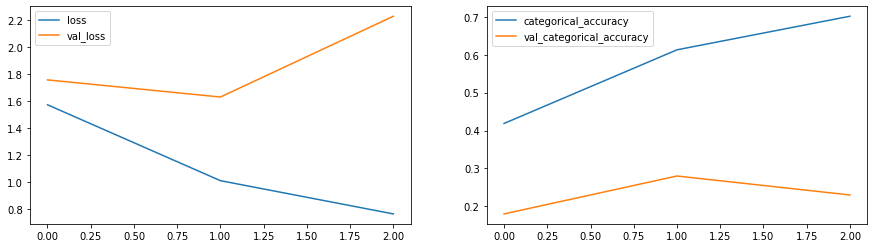

In [13]:
plot(history_1)

## Model 2 - Decreasing the number of dense Layers

In [15]:
model_2 = Sequential()
model_2.add(Conv3D(16, (3,3,3), padding='same',input_shape=(15,100,100,3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(32, (3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, (3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Flatten())
model_2.add(Dense(64,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.25))

model_2.add(Dense(64,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.25))


model_2.add(Dense(5,activation='softmax'))

optimiser = Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_10 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_14 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 7, 50, 50, 32)     13856     
                                                                 
 activation_11 (Activation)  (None, 7, 50, 50, 32)    

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_2 = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_2)

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.5683 - categorical_accuracy: 0.4543 Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-0915_13_06.873581/model-00001-1.56829-0.45429-1.71556-0.18000.h5
14/14 [==============================] - 593s 42s/step - loss: 1.5683 - categorical_accuracy: 0.4543 - val_loss: 1.7156 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.9394 - categorical_accuracy: 0.6329 
Epoch 2: saving model to model_init_2022-07-0915_13_06.873581/model-00002-0.93935-0.63286-2.18358-0.21000.h5
14/14 [==============================] - 584s 42s/step - loss: 0.9394 - categorical_accuracy: 0.6329 - val_loss: 2.1836 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ET

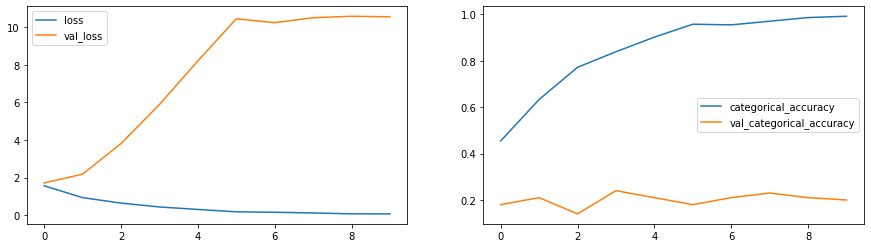

In [17]:
plot(history_2)

## Model 3 - Adding more convolutional layers

In [22]:
model_4 = Sequential()
model_4.add(Conv3D(16, (3,3,3), padding='same',input_shape=(15,100,100,3)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(Conv3D(16, (3,3,3), padding='same',input_shape=(15,100,100,3)))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv3D(32, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(Conv3D(32, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv3D(64, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(Conv3D(64, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Conv3D(128, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
model_4.add(Conv3D(128, (3,3,3), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
        
# model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model_4.add(Dropout(0.25))
        
model_4.add(Flatten())
model_4.add(Dense(64,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))

model_4.add(Dense(64,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))


model_4.add(Dense(5,activation='softmax'))

optimiser = Adam()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_33 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_34 (Conv3D)          (None, 15, 100, 100, 16)  6928      
                                                                 
 activation_34 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                     

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.8317 - categorical_accuracy: 0.3400  Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-0915_13_06.873581/model-00001-1.83171-0.34000-1.67223-0.21000.h5
14/14 [==============================] - 1002s 71s/step - loss: 1.8317 - categorical_accuracy: 0.3400 - val_loss: 1.6722 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.2027 - categorical_accuracy: 0.5343  
Epoch 2: saving model to model_init_2022-07-0915_13_06.873581/model-00002-1.20273-0.53429-1.75923-0.21000.h5
14/14 [==============================] - 952s 68s/step - loss: 1.2027 - categorical_accuracy: 0.5343 - val_loss: 1.7592 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
14/14 [==============================] -

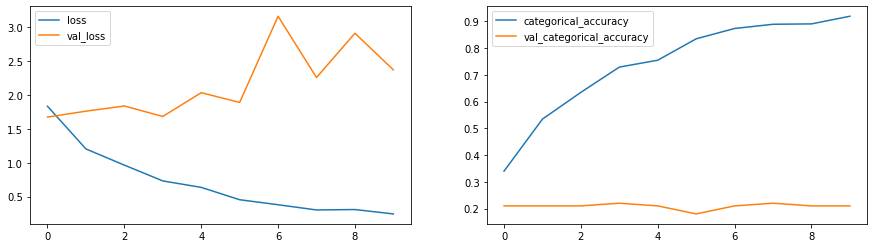

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_4 = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_4)
plot(history_4)

## Model *4* - Decreasing Parameters

In [26]:
model_5 = Sequential()

model_5.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(15,100,100,3)))

model_5.add(Activation('relu'))
model_5.add(BatchNormalization())        
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))       

model_5.add(Conv3D(32, (2, 2, 2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(64, (2, 2, 2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_5.add(Conv3D(128, (2, 2, 2), padding='same'))
model_5.add(Activation('relu'))
model_5.add(BatchNormalization())
# model_5.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
model_5.add(Flatten())
model_5.add(Dense(128,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

model_5.add(Dense(128,activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))

model_5.add(Dense(5,activation='softmax'))

optimiser = Adam()
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 7, 50, 50, 32)    

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.3635 - categorical_accuracy: 0.5171 Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-1009_07_18.116515/model-00001-1.36345-0.51714-1.71865-0.16000.h5
14/14 [==============================] - 520s 37s/step - loss: 1.3635 - categorical_accuracy: 0.5171 - val_loss: 1.7187 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.4732 - categorical_accuracy: 0.8257 
Epoch 2: saving model to model_init_2022-07-1009_07_18.116515/model-00002-0.47317-0.82571-2.98724-0.19000.h5
14/14 [==============================] - 509s 37s/step - loss: 0.4732 - categorical_accuracy: 0.8257 - val_loss: 2.9872 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ET

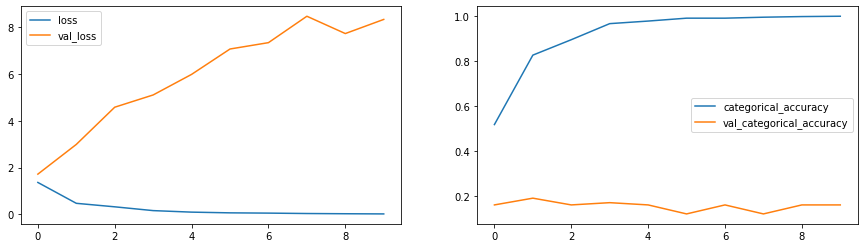

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_5 = model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_5)
plot(history_5)

## Model 5 - Using CNN with LSTM

In [13]:
model_6 = Sequential()

model_6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15,100,100,3)))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))

model_6.add(TimeDistributed(Flatten()))


model_6.add(LSTM(128))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(5, activation='softmax'))

optimiser = Adam()
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50, 50, 32)  

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.4238 - categorical_accuracy: 0.3771 Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-1003_06_04.728707/model-00001-1.42378-0.37714-1.61271-0.18000.h5
14/14 [==============================] - 355s 25s/step - loss: 1.4238 - categorical_accuracy: 0.3771 - val_loss: 1.6127 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.0645 - categorical_accuracy: 0.5843 
Epoch 2: saving model to model_init_2022-07-1003_06_04.728707/model-00002-1.06446-0.58429-1.70754-0.21000.h5
14/14 [==============================] - 349s 25s/step - loss: 1.0645 - categorical_accuracy: 0.5843 - val_loss: 1.7075 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ET

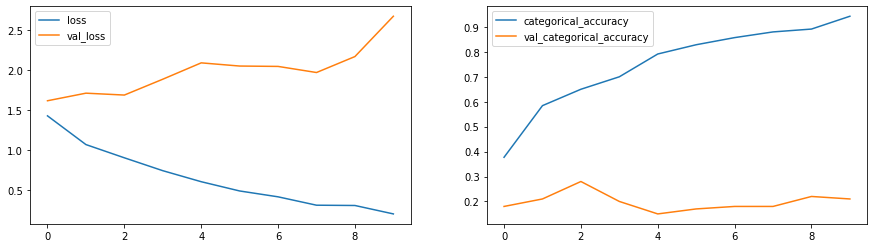

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_6 = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_6)
plot(history_6)

## Model 6 - Just trying out using transfer learning

In [15]:
from keras.applications import mobilenet

In [16]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model_7 = Sequential()
model_7.add(TimeDistributed(mobilenet_transfer,input_shape=(15,100,100,3)))

for layer in model_7.layers:
  layer.trainable = False

model_7.add(TimeDistributed(BatchNormalization()))    
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))       
model_7.add(TimeDistributed(Flatten()))     

model_7.add(LSTM(128))      
model_7.add(Dropout(0.25))      

model_7.add(Dense(128,activation='relu'))
model_7.add(Dropout(0.25))
        
model_7.add(Dense(5, activation='softmax'))    
        
optimiser = Adam()
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_7.summary())

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                       

Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.4988 - categorical_accuracy: 0.3600 Source path =  /content/drive/MyDrive/Guesture_recog/Project_data/val ; batch size = 50

Epoch 1: saving model to model_init_2022-07-1003_06_04.728707/model-00001-1.49884-0.36000-1.34035-0.43000.h5
14/14 [==============================] - 263s 19s/step - loss: 1.4988 - categorical_accuracy: 0.3600 - val_loss: 1.3404 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.9639 - categorical_accuracy: 0.6929 
Epoch 2: saving model to model_init_2022-07-1003_06_04.728707/model-00002-0.96393-0.69286-1.03463-0.60000.h5
14/14 [==============================] - 251s 18s/step - loss: 0.9639 - categorical_accuracy: 0.6929 - val_loss: 1.0346 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ET

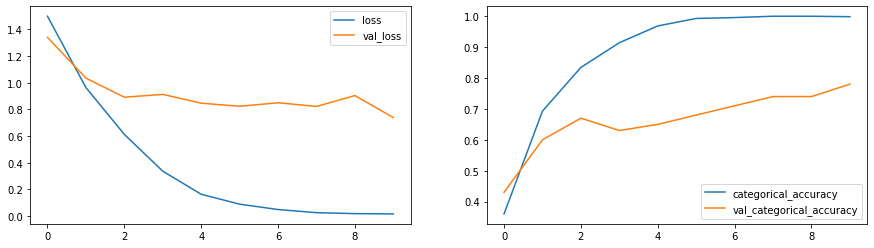

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,verbose = 0, mode = "auto")# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history_7 = model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
print(history_7)
plot(history_7)

## Even though the data is slightly overfitting its predicting correctly on validation data thats not the case with all above 6 models I created so I decided to proceed with this model.

In [21]:
from google.colab import files
files.download("model_init_2022-07-1003_06_04.728707/model-00010-0.01623-0.99857-0.73874-0.78000.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>